In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

### Read data 

In [2]:
train = pd.read_json('../data/train.json')
del train['id']

In [3]:
train.shape

(1604, 4)

In [4]:
train.head()

,band_1,band_2,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
"Number of NaN angle data: {}".format( len(train[train.inc_angle == "na"]))

'Number of NaN angle data: 133'

In [6]:
train = train[train['inc_angle'] != "na"]

In [7]:
train['inc_angle'] = train['inc_angle'].astype('float32')

In [8]:
band_1 = np.asarray(train.iloc[0]['band_1']).reshape((75, 75))
band_2 = np.asarray(train.iloc[0]['band_2']).reshape((75, 75))

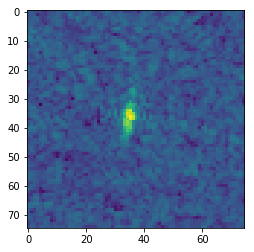

In [9]:
plt.imshow(band_1)

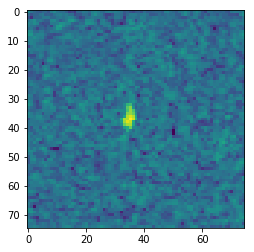

In [10]:
plt.imshow(band_2)

### Display correlation 

In [11]:
print "Max angle: {}".format(train['inc_angle'].max())
print "Min angle: {}".format(train['inc_angle'].min())
print "Mean angle: {}".format(train['inc_angle'].mean())
print "Std angle: {}".format(train['inc_angle'].std())

Max angle: 45.9375
Min angle: 24.7546005249
Mean angle: 39.2687072754
Std angle: 3.83974432945


In [12]:
train['band_1_mean'] = train['band_1'].apply(lambda x: np.asarray(x).mean())
train['band_1_std'] = train['band_1'].apply(lambda x: np.asarray(x).std())
train['band_2_mean'] = train['band_2'].apply(lambda x: np.asarray(x).mean())
train['band_2_std'] = train['band_2'].apply(lambda x: np.asarray(x).std())

In [13]:
train_corr = train[['inc_angle', 'band_1_mean', 'band_2_mean', 'band_1_std', 'band_2_std']]
train_corr.corr()

,inc_angle,band_1_mean,band_2_mean,band_1_std,band_2_std
inc_angle,1.000000,-0.439042,-0.564334,-0.023128,-0.038368
band_1_mean,-0.439042,1.000000,0.744404,0.228981,0.411735
band_2_mean,-0.564334,0.744404,1.000000,0.209700,0.306691
band_1_std,-0.023128,0.228981,0.209700,1.000000,0.863429
band_2_std,-0.038368,0.411735,0.306691,0.863429,1.000000


Linear regression of mean figure value with inc_angle

In [14]:
reg1 = np.polyfit(train['inc_angle'], train['band_1_mean'], 1)
reg2 = np.polyfit(train['inc_angle'], train['band_2_mean'], 1)

Remove dependence on the angle

In [15]:
train['band_1_mean_detrended'] = train['band_1_mean'] - reg1[0] * train['inc_angle'] - reg1[1]
train['band_2_mean_detrended'] = train['band_2_mean'] - reg2[0] * train['inc_angle'] - reg2[1]

In [16]:
train_corr = train[['inc_angle', 'band_1_mean', 'band_2_mean', 'band_1_mean_detrended', 'band_2_mean_detrended']]
train_corr.corr()

,inc_angle,band_1_mean,band_2_mean,band_1_mean_detrended,band_2_mean_detrended
inc_angle,1.000000e+00,-0.439042,-0.564334,-1.294158e-08,-4.571093e-09
band_1_mean,-4.390420e-01,1.000000,0.744404,8.984666e-01,6.015863e-01
band_2_mean,-5.643335e-01,0.744404,1.000000,5.527615e-01,8.255469e-01
band_1_mean_detrended,-1.294158e-08,0.898467,0.552762,1.000000e+00,6.695701e-01
band_2_mean_detrended,-4.571093e-09,0.601586,0.825547,6.695701e-01,1.000000e+00


Then remove dependence on the angle from the figures

In [17]:
train['band_1'][:3]

0    [-27.878361, -27.15416, -28.668615, -29.537971...
1    [-12.242375, -14.920305, -14.920363, -12.66633...
2    [-24.603676, -24.603714, -24.871029, -23.15277...
Name: band_1, dtype: object

In [18]:
def get_detrended_band(band, value):
    band_arr = np.asarray(band).astype(np.float32)
    return np.array(band_arr - value).tolist()

In [19]:
train['band_1_detrended'] = train.apply(
    lambda row: get_detrended_band(row['band_1'], reg1[0] * row['inc_angle']+reg1[1]), axis=1)
train['band_2_detrended'] = train.apply(
    lambda row: get_detrended_band(row['band_2'], reg2[0] * row['inc_angle']+reg2[1]), axis=1)

In [20]:
train['band_1_detrended'][:3]

0    [-5.01898574829, -4.2947845459, -5.80924034119...
1    [7.9412317276, 5.26330184937, 5.26324367523, 7...
2    [-1.11243629456, -1.11247444153, -1.3797893524...
Name: band_1_detrended, dtype: object

In [21]:
band_1_detrended = np.asarray(train.iloc[0]['band_1_detrended']).reshape((75, 75))
band_2_detrended = np.asarray(train.iloc[0]['band_2_detrended']).reshape((75, 75))

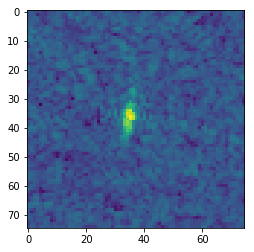

In [22]:
plt.imshow(band_1_detrended)

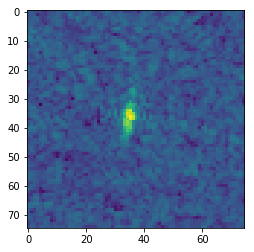

In [24]:
plt.imshow(band_1)

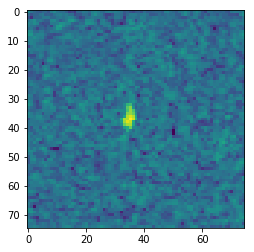

In [23]:
plt.imshow(band_2_detrended)

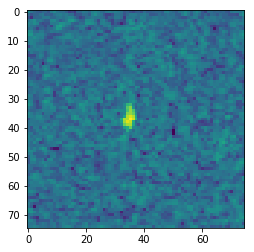

In [27]:
plt.imshow(band_2)